In [1]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached scikit_learn-1.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0
    Uninstalling scikit-learn-1.0:
      Successfully uninstalled scikit-learn-1.0


In [2]:
pip install pymorphy2

  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Using cached DAWG_Python-0.7.2-py2.py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2023.5.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (769 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly

  Using cached plotly-5.14.1-py2.py3-none-any.whl (15.3 MB)
  Using cached tenacity-8.2.2-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [7]:
import os
import re
from tqdm.notebook import tqdm
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
from sklearn.feature_extraction.text import (
    TfidfVectorizer, 
    CountVectorizer
)
from datetime import datetime, timedelta
import pymorphy2 as pm
import nltk
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
print('cores:', N_CORES)
pd.set_option('display.max_colwidth', 100)

cores: 5


## 1. Data preparation

In [8]:
df = pd.read_csv('posts.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5913 non-null   int64  
 1   col_text_x          4647 non-null   object 
 2   col_from_id         5913 non-null   int64  
 3   col_owner_id        5913 non-null   int64  
 4   col_views_count     2850 non-null   float64
 5   col_reposts_count   5908 non-null   float64
 6   col_likes_count     5913 non-null   int64  
 7   col_comments_count  5913 non-null   int64  
 8   col_date            5913 non-null   object 
 9   group               5913 non-null   object 
 10  col_video_id        5913 non-null   int64  
 11  has_photo           5913 non-null   int64  
 12  col_lang            5913 non-null   object 
 13  col_sent            5913 non-null   object 
 14  sent_prob           5913 non-null   float64
dtypes: float64(3), int64(7), object(5)
memory usage: 693.1+

In [10]:
df.head()

,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,col_video_id,has_photo,col_lang,col_sent,sent_prob
0,0,NaN,-23777199,-23777199,375.0,0.0,13,0,2023-05-19 13:55:23,gsom_abiturient,0,1,th,unknown,0.000000
1,0,"⚡⚡ Будь активным! Это девиз выпускника ВШМ СПбГУ Хантера Кейвуда. Как он работает на практике, Х...",-20449089,-20449089,255.0,1.0,2,0,2023-05-18 16:23:00,gsom_ma,0,0,th,unknown,0.000000
2,0,ВШМ СПбГУ вошла в тройку лидеров среди российских вузов — участников предметных рейтингов Агентс...,-168,-168,425.0,3.0,5,0,2023-05-23 12:46:46,gsom_spbu,0,1,th,unknown,0.000000
3,1,Может ли Minecraft быть полезным для управления проектами? Конечно же да 🙌\n \nСтуденты и выпуск...,-23777199,-23777199,917.0,4.0,4,0,2023-05-15 14:42:00,gsom_abiturient,1,0,ru,neutral,0.996736
4,1,Может ли Minecraft быть полезным для управления проектами? Конечно же да 🙌 \n \nСтуденты и выпус...,-20449089,-20449089,542.0,1.0,3,0,2023-05-15 15:23:00,gsom_ma,0,0,ru,neutral,0.996736


In [11]:
## приводим к московскому времени, добавляем дни недели
df['col_date'] = pd.to_datetime(df.col_date, format='%Y-%m-%d %H:%M:%S')
df['col_date'] = df['col_date'] + timedelta(hours=3)
df['day_of_week'] = df['col_date'].dt.dayofweek

In [12]:
# Set day & nighttime based your specified time frames
df.loc[df.set_index('col_date').index.indexer_between_time('00:00', '5:30'), 'd-n'] = 'night'
df.loc[df.set_index('col_date').index.indexer_between_time('5:30', '11:59'), 'd-n'] = 'morning'
df.loc[df.set_index('col_date').index.indexer_between_time('11:59', '16:00'), 'd-n'] = 'day'
df.loc[df.set_index('col_date').index.indexer_between_time('16:00', '00:00'), 'd-n'] = 'evening'

In [13]:
# Set day & nighttime based your specified time frames
df['month'] = df['col_date'].dt.month
df['year'] = df['col_date'].dt.year

In [14]:
## Удаляем репосты
df = df.dropna(subset=['col_text_x'])
df.shape

(4647, 19)

In [15]:
## Посты, совершенные внешними пользователями. Рекламные посты или посты во время, когда кгруппа была неофициальной
df.loc[df['col_from_id'] != df['col_owner_id']]

,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,col_video_id,has_photo,col_lang,col_sent,sent_prob,day_of_week,d-n,month,year
1596,532,"Здравствуйте,хочу учится по направлению маркетинг,какие экзамены нужно сдавать для этого?заранее...",277997748,-23777199,NaN,0.0,0,1,2015-03-07 19:30:47,gsom_abiturient,0,1,ru,neutral,0.997724,5,evening,3,2015
1599,533,Добрый день! а подскажите пожалуйста за что отчисляют из спбгу вшм (баклавриат) в плане академич...,167248684,-23777199,NaN,1.0,0,1,2013-06-26 21:27:30,gsom_abiturient,0,1,ru,neutral,0.995808,2,evening,6,2013
1602,534,А в каком месте строится новый кампус ВШМ?,13448472,-23777199,NaN,0.0,0,3,2013-04-03 12:26:25,gsom_abiturient,0,0,ru,neutral,0.998253,2,day,4,2013
1605,535,"Скажите пожалуйста, когда дни открытых дверей будут?",39389159,-23777199,NaN,0.0,0,1,2013-01-28 23:05:25,gsom_abiturient,0,0,ru,neutral,0.997733,0,evening,1,2013
1608,536,"ребят, сложно учиться на международного менеджмента?",40187092,-23777199,NaN,0.0,0,1,2012-05-10 14:52:32,gsom_abiturient,0,0,ru,neutral,0.997904,3,day,5,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5908,3972,"Да уже все поняли, нафига дважды писать?:)",584249,-168,NaN,0.0,0,0,2008-08-27 16:02:10,gsom_spbu,0,0,th,unknown,0.000000,2,evening,8,2008
5909,3973,уважаемые студенты СПбГУ(кроме первых курсов)!кто хочет принять участие в организации Точки Отсч...,1012889,-168,NaN,0.0,0,0,2008-08-17 15:00:14,gsom_spbu,0,0,th,unknown,0.000000,6,day,8,2008
5910,3974,спасибо,375969,-168,NaN,0.0,0,0,2008-08-17 12:11:52,gsom_spbu,1,0,th,unknown,0.000000,6,day,8,2008
5911,3975,с 25,421507,-168,NaN,0.0,0,0,2008-08-15 16:47:42,gsom_spbu,1,0,th,unknown,0.000000,4,evening,8,2008


In [16]:
df = df.loc[df['col_from_id'] == df['col_owner_id']]

In [17]:
## Видим, что есть пропущенные значения в views. В вк просмотры появились только с 2016 года, так что заменим на 0
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3763 entries, 1 to 5677
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          3763 non-null   int64         
 1   col_text_x          3763 non-null   object        
 2   col_from_id         3763 non-null   int64         
 3   col_owner_id        3763 non-null   int64         
 4   col_views_count     2806 non-null   float64       
 5   col_reposts_count   3763 non-null   float64       
 6   col_likes_count     3763 non-null   int64         
 7   col_comments_count  3763 non-null   int64         
 8   col_date            3763 non-null   datetime64[ns]
 9   group               3763 non-null   object        
 10  col_video_id        3763 non-null   int64         
 11  has_photo           3763 non-null   int64         
 12  col_lang            3763 non-null   object        
 13  col_sent            3763 non-null   object      

In [18]:
df['col_views_count'] = df['col_views_count']. fillna(0)

In [19]:
#Оказалось, что есть полные посты-дубликаты.
df = df.drop_duplicates(subset=['col_text_x','col_owner_id','col_views_count', 'col_likes_count', 'col_date'])

In [20]:
pattern = '🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой'
df.loc[(df['col_text_x'].str.contains(pattern, case=False, na=False))]

,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,col_video_id,has_photo,col_lang,col_sent,sent_prob,day_of_week,d-n,month,year
96,32,🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой про...,-23777199,-23777199,801.0,1.0,3,0,2023-02-27 16:30:00,gsom_abiturient,0,0,ru,neutral,0.997669,0,evening,2,2023
103,34,🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой про...,-20449089,-20449089,470.0,2.0,2,0,2023-02-27 16:30:00,gsom_ma,0,0,ru,neutral,0.998429,0,evening,2,2023
278,92,🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой про...,-168,-168,1498.0,5.0,5,0,2023-02-27 16:30:00,gsom_spbu,0,1,ru,neutral,0.993785,0,evening,2,2023


## OneHotEncoder

In [21]:
nominal_features = ['group', 'has_photo', 'day_of_week', 'd-n', 'month']
df[nominal_features].tail(3)

,group,has_photo,day_of_week,d-n,month
5656,gsom_spbu,0,3,evening,5
5664,gsom_spbu,0,1,day,4
5677,gsom_spbu,0,0,evening,3


In [22]:
df = pd.get_dummies(data=df, columns=['group', 'has_photo', 'day_of_week', 'd-n', 'month'])

In [23]:
df.head()

,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,col_video_id,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1,0,"⚡⚡ Будь активным! Это девиз выпускника ВШМ СПбГУ Хантера Кейвуда. Как он работает на практике, Х...",-20449089,-20449089,255.0,1.0,2,0,2023-05-18 19:23:00,0,...,0,0,1,0,0,0,0,0,0,0
2,0,ВШМ СПбГУ вошла в тройку лидеров среди российских вузов — участников предметных рейтингов Агентс...,-168,-168,425.0,3.0,5,0,2023-05-23 15:46:46,0,...,0,0,1,0,0,0,0,0,0,0
3,1,Может ли Minecraft быть полезным для управления проектами? Конечно же да 🙌\n \nСтуденты и выпуск...,-23777199,-23777199,917.0,4.0,4,0,2023-05-15 17:42:00,1,...,0,0,1,0,0,0,0,0,0,0
4,1,Может ли Minecraft быть полезным для управления проектами? Конечно же да 🙌 \n \nСтуденты и выпус...,-20449089,-20449089,542.0,1.0,3,0,2023-05-15 18:23:00,0,...,0,0,1,0,0,0,0,0,0,0
5,1,Поздравляем лауреатов премии имени Питера Дракера! 👏👏👏\n \nВ «Михайловской даче» состоялась 27-я...,-168,-168,4280.0,8.0,104,2,2023-05-22 20:36:49,0,...,0,0,1,0,0,0,0,0,0,0


## 2. Text processing

In [24]:
LANG = 'russian'

In [25]:
MORPH = pm.MorphAnalyzer()
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words(LANG)
STOPWORDS = STOPWORDS + ['https', 'http', 'vk', 'cc', 'clck', 'ru', 'www', 'com', 'id', 'in','это','it','to','up','of','all',
                        'and','the','наш','ваш','почему','очень','многое','ещё','весь', 'весь', 'свой', 'который', 'с', 'спбгу',
                        'spbu', 'вшм', 'студент', 'gsom', 'ma', 'мочь']

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def preprocessing(sentence, as_list=False):
    s = re.sub('[^а-яА-Яa-zA-Z]+', ' ', sentence).strip().lower()
    s = re.sub('ё', 'е', s)
    funсtion_words = {'INTJ', 'PRCL', 'CONJ', 'PREP'}
    lemmatized_words = list(map(lambda word: MORPH.parse(word)[0], s.split()))
    result = []
    for word in lemmatized_words:
        if word.tag.POS not in funсtion_words:
            result.append(word.normal_form)
    result = [w for w in result if w not in STOPWORDS]
    if as_list:
        return result
    else:
        return ' '.join(result)
    
def apply_parallel(texts, func, n_cores=2):
    pool = Pool(n_cores)
    split = np.array_split(texts, n_cores)
    res = [item for sub in pool.map(func, split) for item in sub]
    pool.close()
    pool.join()
    return res

def preprocessing_list(sentences):
    return [preprocessing(s) for s in sentences]

In [27]:
%%time
proc = apply_parallel(df.col_text_x, preprocessing_list, n_cores=N_CORES)

CPU times: user 22.8 ms, sys: 48.1 ms, total: 70.9 ms
Wall time: 12.4 s


In [28]:
df.loc[:, 'proc'] = proc
print(df.shape)
df.head(1)

(3763, 43)


,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,col_video_id,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,proc
1,0,"⚡⚡ Будь активным! Это девиз выпускника ВШМ СПбГУ Хантера Кейвуда. Как он работает на практике, Х...",-20449089,-20449089,255.0,1.0,2,0,2023-05-18 19:23:00,0,...,0,1,0,0,0,0,0,0,0,активный девиз выпускник хантер кейвуд работать практика хантереть рассказывать новый выпуск под...


In [29]:
#df['proc'] = df['proc'].apply(word_tokenize)

In [30]:
#df_posts=df['proc']

In [31]:
#df_posts.to_csv('df_posts.csv')

## 3. Modelling

In [32]:
MAX_DF = .6
MIN_DF = 10

In [33]:
def text_features(data, vectorizer):
    print('total texts:', len(data))
    features = vectorizer.fit_transform(data)
    print(
        'features shape:', features.shape, 
        'max:', np.max(features), 
        'min:', np.min(features)
    )
    return features, vectorizer

In [34]:
%%time
vectorizer=TfidfVectorizer(
    ngram_range=(1, 2), 
    max_df=MAX_DF, 
    min_df=MIN_DF,
    max_features = None
)
features, vectorizer = text_features(
    df['proc'], 
    vectorizer=vectorizer
)

total texts: 3763
features shape: (3763, 3377) max: 1.0 min: 0.0
CPU times: user 347 ms, sys: 14.2 ms, total: 361 ms
Wall time: 360 ms


In [35]:
print(features.todense())

[[0.         0.         0.         ... 0.17340674 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [36]:
vectorizer.vocabulary_

{'активный': 405,
 'выпускник': 723,
 'работать': 2515,
 'практика': 2245,
 'рассказывать': 2576,
 'новый': 1705,
 'выпуск': 721,
 'подкаст': 2069,
 'жизнь': 1001,
 'стиль': 2934,
 'окончить': 1808,
 'государственный': 809,
 'университет': 3104,
 'university': 349,
 'поступить': 2206,
 'жить': 1004,
 'россия': 2651,
 'заниматься': 1055,
 'являться': 3367,
 'основатель': 1865,
 'президент': 2286,
 'российский': 2644,
 'комитет': 1300,
 'связь': 2707,
 'америка': 425,
 'интервью': 1171,
 'обучение': 1771,
 'давать': 828,
 'несколько': 1686,
 'важный': 548,
 'совет': 2809,
 'находиться': 1654,
 'начало': 1657,
 'карьерный': 1252,
 'путь': 2505,
 'слушать': 2776,
 'яндекс': 3373,
 'музыка': 1594,
 'yandex': 370,
 'новый выпуск': 1706,
 'выпуск подкаст': 722,
 'подкаст жизнь': 2070,
 'жизнь стиль': 1002,
 'государственный университет': 812,
 'карьерный путь': 1258,
 'яндекс музыка': 3374,
 'войти': 639,
 'тройка': 3056,
 'лидер': 1409,
 'вуз': 698,
 'участник': 3163,
 'рейтинг': 2612,
 'аге

In [37]:
vectorizer.get_feature_names_out().shape

(3377,)

#### Train test split

In [38]:
train_df = df[df.col_date <= '2021-04-01']
train_df.shape

(2744, 43)

In [39]:
valid_df = df[(df.col_date < '2022-04-01')&(df.col_date > '2021-04-01')]
valid_df.shape

(401, 43)

In [40]:
test_df =  df[df.col_date >= '2022-04-01']
test_df.col_date.sort_values(ascending=True)

502    2022-04-01 15:20:28
1004   2022-04-01 16:28:49
408    2022-04-01 17:35:00
499    2022-04-04 15:22:00
405    2022-04-05 08:41:00
               ...        
11     2023-05-18 13:45:10
1      2023-05-18 19:23:00
8      2023-05-19 14:40:37
5      2023-05-22 20:36:49
2      2023-05-23 15:46:46
Name: col_date, Length: 618, dtype: datetime64[ns]

In [41]:
X_train = train_df['proc']
X_valid = valid_df['proc']
X_test = test_df['proc']

In [42]:
train_df.columns

Index(['Unnamed: 0', 'col_text_x', 'col_from_id', 'col_owner_id',
       'col_views_count', 'col_reposts_count', 'col_likes_count',
       'col_comments_count', 'col_date', 'col_video_id', 'col_lang',
       'col_sent', 'sent_prob', 'year', 'group_gsom_abiturient',
       'group_gsom_ma', 'group_gsom_spbu', 'has_photo_0', 'has_photo_1',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'd-n_day',
       'd-n_evening', 'd-n_morning', 'd-n_night', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'proc'],
      dtype='object')

In [43]:
features = ['group_gsom_abiturient', 'group_gsom_ma',
       'group_gsom_spbu', 'd-n_day', 'd-n_evening', 'd-n_morning', 'd-n_night', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'proc']

In [44]:
X_train = train_df[features]
X_test = test_df[features]
X_valid = valid_df[features]

In [45]:
X_train.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,proc
684,1,0,0,0,0,1,0,1,0,0,0,0,0,0,перспектива выпускник гму совмещать работа стартап программа государственный муниципальный управ...


In [46]:
X_test.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,proc
1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,активный девиз выпускник хантер кейвуд работать практика хантереть рассказывать новый выпуск под...


<AxesSubplot:>

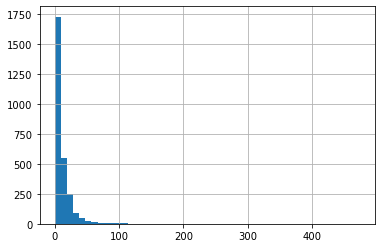

In [47]:
train_df.col_likes_count.hist(bins=50)

<AxesSubplot:>

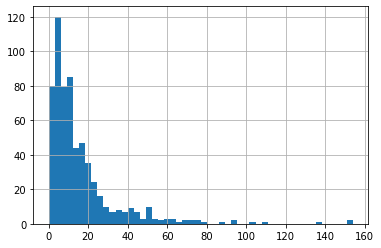

In [48]:
test_df.col_likes_count.hist(bins=50)

## Попытка добавить не текстовые фичи в датасет

In [49]:
 X_train_text, vectorizer = text_features(
    X_train['proc'], 
    vectorizer=vectorizer)

X_test_text = vectorizer.transform(X_test['proc'])
X_valid_text = vectorizer.transform(X_valid['proc'])

total texts: 2744
features shape: (2744, 2424) max: 1.0 min: 0.0


In [50]:
X_train_text = pd.DataFrame.sparse.from_spmatrix(X_train_text)
X_train_text.columns = vectorizer.get_feature_names_out()
X_train_text.head(1)

,abiturient,abiturient index,about,admissions,al,analytics,analytics big,annual,are,at,...,юрий,юрий евгениевич,являться,язык,язык модель,январь,январь год,яндекс,яркий,ярмарка
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
X_valid_text = pd.DataFrame.sparse.from_spmatrix(X_valid_text)
X_valid_text.columns = vectorizer.get_feature_names_out()
X_valid_text.head(1)

,abiturient,abiturient index,about,admissions,al,analytics,analytics big,annual,are,at,...,юрий,юрий евгениевич,являться,язык,язык модель,январь,январь год,яндекс,яркий,ярмарка
0,0.152008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
X_test_text = pd.DataFrame.sparse.from_spmatrix(X_test_text)
X_test_text.columns = vectorizer.get_feature_names_out()
X_test_text.head(1)

,abiturient,abiturient index,about,admissions,al,analytics,analytics big,annual,are,at,...,юрий,юрий евгениевич,являться,язык,язык модель,январь,январь год,яндекс,яркий,ярмарка
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.126926,0.0,0.0,0.0,0.0,0.178307,0.0,0.0


In [53]:
X_train.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train, X_train_text], axis=1)
X_train.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,...,юрий,юрий евгениевич,являться,язык,язык модель,январь,январь год,яндекс,яркий,ярмарка
0,1,0,0,0,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
X_valid.reset_index(drop=True, inplace=True)
X_valid = pd.concat([X_valid, X_valid_text], axis=1)
X_valid.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,...,юрий,юрий евгениевич,являться,язык,язык модель,январь,январь год,яндекс,яркий,ярмарка
0,1,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
X_test.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test, X_test_text], axis=1)
X_test.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,...,юрий,юрий евгениевич,являться,язык,язык модель,январь,январь год,яндекс,яркий,ярмарка
0,0,1,0,0,1,0,0,0,0,0,...,0.0,0.0,0.126926,0.0,0.0,0.0,0.0,0.178307,0.0,0.0


In [56]:
#X_test_text = pd.DataFrame.sparse.from_spmatrix(X_test_text)

In [57]:
#X_test = pd.merge(X_test_text, X_test, how='inner', left_index = True,  right_index = True)
#X_test

In [58]:
vectorizer.get_feature_names_out().shape

(2424,)

In [59]:
vectorizer.get_feature_names_out()[:3]

array(['abiturient', 'abiturient index', 'about'], dtype=object)

In [60]:
y_train = train_df['col_likes_count']
y_test = test_df['col_likes_count']
y_valid = valid_df['col_likes_count']

In [61]:
X_train = X_train.drop(columns=['proc'])

In [62]:
X_test = X_test.drop(columns=['proc'])

In [63]:
X_valid = X_valid.drop(columns=['proc'])

In [64]:
X_test.shape

(618, 2438)

In [65]:
#X_train.columns.astype(str)

In [66]:
#X_test.columns.astype(str)

In [67]:
#np.isnan(X_train.data).any()

In [68]:
#np.isnan(X_test.data).any()

In [69]:
np.isnan(y_train).any()

False

In [70]:
np.isnan(y_test).any()

False

In [71]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

## Tune the threshold

import plotly.figure_factory as ff

group_0 = X_train_ros[y_train_ros == 0]
group_1 = X_train_ros[y_train_ros == 1]

p_0 = reg.predict_proba(group_0)[:, 1]
p_1 = reg.predict_proba(group_1)[:, 1]

group_labels = ['Low impact', 'High impact']
fig = ff.create_distplot([p_0, p_1], group_labels, bin_size=0.05, show_rug=False)
fig.update_layout(title_text='Distribution of probabilities in ground truth groups', width=640, height=480, xaxis_title="Probability", template='plotly_dark')
fig.show()

print("ROC AUC:", round(roc_auc_score(y_test_binary, p_test[:, 1]>0.85), 4))

## RandomForest with Grid Search

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [73]:
forest = RandomForestRegressor(random_state=42)

In [74]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [75]:
param_grid_forest = dict(
    n_estimators=[50, 100, 150, 200],
    max_depth=[2, 3, 5, 7, 10]
    )

grid_search_forest = GridSearchCV(
    estimator=forest, 
    param_grid=param_grid_forest, 
    cv=tscv, 
    n_jobs=-1).fit(X_train, y_train)

print("The best hyperparameters are ", grid_search_forest.best_params_)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/uti

The best hyperparameters are  {'max_depth': 10, 'n_estimators': 200}


In [76]:
forest = RandomForestRegressor(
    n_estimators = grid_search_forest.best_params_["n_estimators"],
    max_depth    = grid_search_forest.best_params_["max_depth"],
    random_state = 42)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [77]:
y_pred_rf_train = forest.predict(X_train)

In [78]:
y_pred_rf_valid = forest.predict(X_valid)

In [79]:
y_pred_rf = forest.predict(X_test)

In [80]:
print("MAE:", round( mean_absolute_error(y_train, y_pred_rf_train ), 3))
print("RMSE:", round(mean_squared_error(y_train, y_pred_rf_train, squared=False), 3))
print("r2_score: " + str(r2_score(y_train, y_pred_rf_train).round(2)) + "  ")
print("WMAPE: ",  round(wmape(y_train, y_pred_rf_train), 3))

MAE: 7.353
RMSE: 11.476
r2_score: 0.66  
WMAPE:  0.595


In [81]:
print("MAE:", round( mean_absolute_error(y_test, y_pred_rf ), 3))
print("RMSE:", round(mean_squared_error(y_test, y_pred_rf , squared=False), 3))
print("r2_score: " + str(r2_score(y_test, y_pred_rf ).round(2)) + "  ")
print("WMAPE: ",  round(wmape(y_test, y_pred_rf), 3))

MAE: 9.449
RMSE: 17.12
r2_score: 0.13  
WMAPE:  0.583


## Feature importances

In [82]:
feature_importances = pd.DataFrame(forest.feature_importances_)


In [83]:
feature_names = pd.DataFrame(vectorizer.get_feature_names_out())


In [84]:
importances = pd.merge(feature_names, feature_importances, how='inner', left_index = True,  right_index = True)
importances.sort_values(by = ['0_y'], ascending=False).head(20)

,0_x,0_y
155,instagram аккаунт,0.185644
196,miba,0.118602
1548,политика,0.073801
1674,преподаватель,0.041735
1837,рада видеть,0.034216
1,abiturient index,0.028533
1917,риск,0.019527
2406,эфир,0.018703
1943,руководство,0.015172
1085,мария,0.011751


forest_importances = pd.Series(forest.feature_importances_, index=text_features)

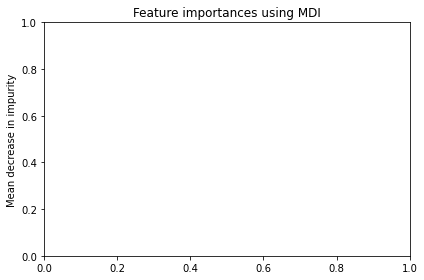

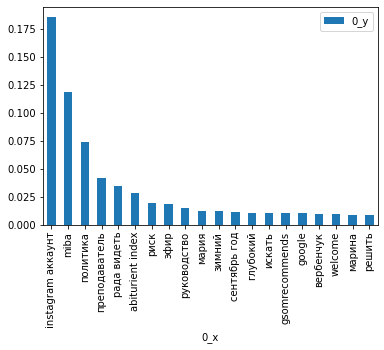

In [85]:
fig, ax = plt.subplots()
importances.sort_values(by = ['0_y'], ascending=False).head(20).plot.bar(x='0_x')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Visualization of the tree

In [86]:
from sklearn import tree

plt.figure(figsize=(20,20))
_ = tree.plot_tree(forest.estimators_[0], filled=True, max_depth = 3)

### XGboost with Grid Search

In [87]:
pip install xgboost

  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [88]:
import xgboost as xgb 

In [89]:
regressor=xgb.XGBRegressor(eval_metric='rmse', random_state=42)

In [90]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [91]:
param_grid = {"max_depth":    [3, 5, 7],
              "n_estimators": [50, 150, 200],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(regressor, param_grid, cv=tscv, n_jobs = -1).fit(X_train, y_train)

print("The best hyperparameters for XGBoost regressor are ",search.best_params_)

The best hyperparameters for XGBoost regressor are  {'learning_rate': 0.015, 'max_depth': 3, 'n_estimators': 150}


In [92]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse',
                           random_state=42
                          )

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [93]:
y_pred_xgb_train = regressor.predict(X_train)

In [94]:
y_pred_xgb_valid = regressor.predict(X_valid)

In [95]:
y_pred_xgb = regressor.predict(X_test)

In [96]:
print("XGBR MAE:", round( mean_absolute_error(y_train, y_pred_xgb_train), 3))
print("XGBR RMSE:", round(mean_squared_error(y_train, y_pred_xgb_train, squared=False), 3))
print("XGBR R2:", round(r2_score(y_train, y_pred_xgb_train), 3))
print("XGBR WMAPE: ",  round(wmape(y_train, y_pred_xgb_train), 3))

XGBR MAE: 8.119
XGBR RMSE: 13.984
XGBR R2: 0.494
XGBR WMAPE:  0.661


In [97]:
print("XGBR MAE:", round( mean_absolute_error(y_valid, y_pred_xgb_valid), 3))
print("XGBR RMSE:", round(mean_squared_error(y_valid, y_pred_xgb_valid, squared=False), 3))
print("XGBR R2:", round(r2_score(y_valid, y_pred_xgb_valid), 3))
print("XGBR WMAPE: ",  round(wmape(y_valid, y_pred_xgb_valid), 3))

XGBR MAE: 8.647
XGBR RMSE: 16.492
XGBR R2: 0.114
XGBR WMAPE:  0.649


In [98]:
print("XGBR MAE:", round( mean_absolute_error(y_test, y_pred_xgb), 3))
print("XGBR RMSE:", round(mean_squared_error(y_test, y_pred_xgb, squared=False), 3))
print("XGBR R2:", round(r2_score(y_test, y_pred_xgb), 3))
print("XGBR WMAPE: ",  round(wmape(y_test, y_pred_xgb), 3))

XGBR MAE: 9.921
XGBR RMSE: 18.352
XGBR R2: 0.001
XGBR WMAPE:  0.611


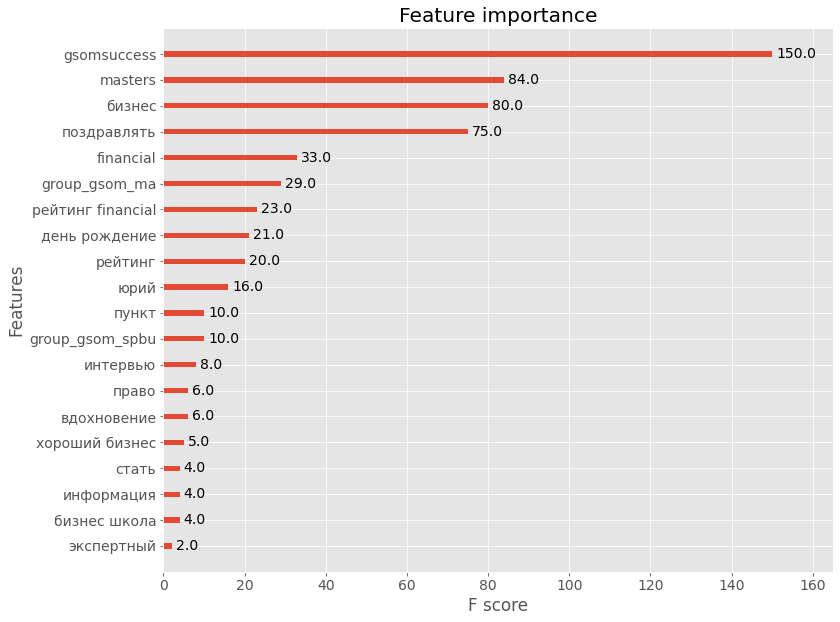

In [99]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(12, 10))
plot_importance(regressor, max_num_features=20, ax=ax)
plt.show();

### Light Gradient Boosting Machine

In [100]:
pip install lightgbm

  Using cached lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [101]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [102]:
lgr = LGBMRegressor(random_state = 42,)
lgr.fit(X_train, y_train)

LGBMRegressor(random_state=42)

In [103]:
y_pred_lgr_train = lgr.predict(X_train)
y_pred_lgr_valid = lgr.predict(X_valid)

In [104]:
y_pred_lgr = lgr.predict(X_test)

In [105]:
print("LightGBM MAE:", round( mean_absolute_error(y_train, y_pred_lgr_train), 3))
print("LightGBM RMSE:", round(mean_squared_error(y_train, y_pred_lgr_train, squared=False), 3))
print("LightGBM R2: ", round(r2_score(y_train, y_pred_lgr_train), 3))
print("LightGBM WMAPE: ",  round(wmape(y_train, y_pred_lgr_train), 3))

LightGBM MAE: 4.973
LightGBM RMSE: 10.69
LightGBM R2:  0.704
LightGBM WMAPE:  0.41


In [106]:
print("LightGBM MAE:", round( mean_absolute_error(y_valid, y_pred_lgr_valid), 3))
print("LightGBM RMSE:", round(mean_squared_error(y_valid, y_pred_lgr_valid, squared=False), 3))
print("LightGBM R2: ", round(r2_score(y_valid, y_pred_lgr_valid), 3))
print("LightGBM WMAPE: ",  round(wmape(y_valid, y_pred_lgr_valid), 3))

LightGBM MAE: 8.725
LightGBM RMSE: 15.32
LightGBM R2:  0.235
LightGBM WMAPE:  0.659


In [107]:
print("LightGBM MAE:", round( mean_absolute_error(y_test, y_pred_lgr), 3))
print("LightGBM RMSE:", round(mean_squared_error(y_test, y_pred_lgr, squared=False), 3))
print("LightGBM R2: ", round(r2_score(y_test, y_pred_lgr), 3))
print("LightGBM WMAPE: ",  round(wmape(y_test, y_pred_lgr), 3))

LightGBM MAE: 10.989
LightGBM RMSE: 18.235
LightGBM R2:  0.014
LightGBM WMAPE:  0.678
